### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from model import *

In [4]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.2.4-tf
TensorFlow version: 1.14.0


In [9]:
K.set_image_data_format('channels_last')

In [10]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [11]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [12]:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

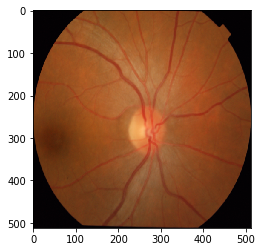

(50, 512, 512, 3)


In [13]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)

In [14]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [37]:
green_channel_train = []
for i in (img_train):
    green = np.zeros(i.shape)
    green[:,:,1] = i[:,:,1]
    green_channel_train.append(green)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

In [38]:
gen = data_generator(green_channel_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

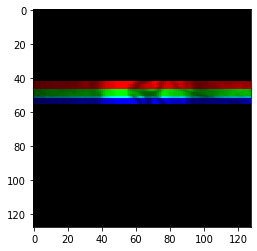

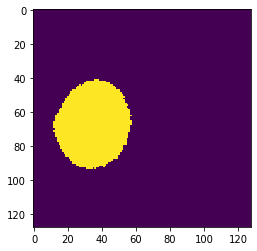

In [39]:
plt.imshow(np.squeeze(batch[0][0]))
plt.show()
plt.imshow(np.squeeze(batch[1][0]))

In [40]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))
print(weights_folder)

C:\Users\Rosana\Documents\Mestrado\dissertacao\codigo_unet\models_weights\OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss


In [41]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [42]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

In [44]:
green_channel_test = []
for i in (img_test):
    green = np.zeros(i.shape)
    green[:,:,1] = i[:,:,1]
    green_channel_test.append(green)

In [45]:
X_valid, Y_valid = next(data_generator(green_channel_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

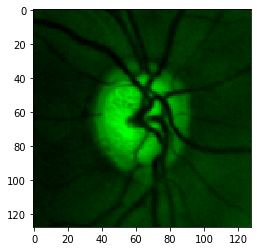

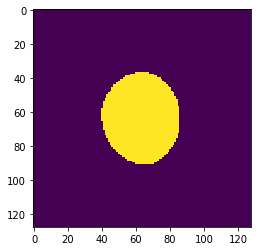

In [46]:
plt.imshow(np.squeeze(X_valid[0]))
plt.show()
plt.imshow(np.squeeze(Y_valid[0]))

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [47]:
history = model.fit_generator(data_generator(green_channel_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                              
                              validation_data=(X_valid, Y_valid),
                              epochs=700, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_green.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_green.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/1
99/99 [==============================] - 49s 490ms/step - loss: 1.6670 - mean_IOU_gpu: 0.0056 - dice_metric: 0.0111 - val_loss: 1.4890 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


### Visual check

image #0


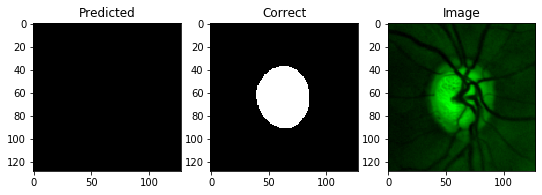

IOU: 0.0
Dice: 0.0
0.0
0.0


In [51]:
pred_iou, pred_dice, pred_disc = predict(green_channel_test, X_valid, Y_valid, model)

print(np.mean(pred_iou))
print(np.mean(pred_dice))

Acquiring scores for the validation set:

### Training and Test disc

In [52]:
X_valid, Z_valid = next(data_generator(green_channel_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [53]:
history = model.fit_generator(data_generator(green_channel_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=700, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_green.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_green.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/1
99/99 [==============================] - 47s 479ms/step - loss: 0.9989 - mean_IOU_gpu: 4.8342e-05 - dice_metric: 9.6644e-05 - val_loss: 0.9581 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


image #0


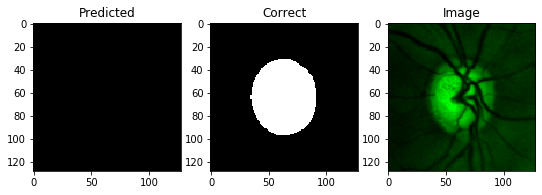

IOU: 0.0
Dice: 0.0
0.0
0.0


In [54]:
pred_iou, pred_dice, pred_disc = predict(green_channel_test, X_valid, Z_valid, model)

print(np.mean(pred_iou))
print(np.mean(pred_dice))

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

In [ ]:
cdrs = calculate_cdr(pred_cup, pred_disc)
cdrs